In [24]:
import colorsys
import random
import warnings
from collections import OrderedDict
from importlib import import_module
from multiprocessing import Lock, Pool

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from scipy.ndimage import measurements
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import watershed
from torch.utils.data import DataLoader

from dataloader.train_loader import FileLoader
from misc.utils import get_bounding_box, remove_small_objects
from models.hovernet.net_desc import create_model
from models.hovernet.targets import gen_targets
from run_utils.utils import convert_pytorch_checkpoint

In [25]:
conic_model = create_model(
    num_types=7, #4 for custom dataset 
    pretrained_backbone="exp_output/local/resnet50-0676ba61.pth",
)
checkpoint = torch.load(
    "exp_output/local/models/baseline/00/model/00/net_epoch=50.tar",
    map_location=torch.device("cpu"),
)
conic_model.load_state_dict(convert_pytorch_checkpoint(checkpoint["desc"]))

Loading: exp_output/local/resnet50-0676ba61.pth


<All keys matched successfully>

In [5]:
fileloader = FileLoader(
    "exp_output/local/data/images.npy",
    "exp_output/local/data/labels.npy",
    with_type=True,
    input_shape=[256, 256],
    mask_shape=[256, 256],
    run_mode="infer",
    target_gen_func=[gen_targets, {}],
)

dataloader = DataLoader(
    fileloader,
    num_workers=1,
    batch_size=1,
    shuffle=False,
    drop_last=False,
)

In [6]:
def infer_step(batch_data, model):
    ####
    patch_imgs = batch_data

    patch_imgs_gpu = patch_imgs.type(torch.float32)  # to NCHW
    patch_imgs_gpu = patch_imgs_gpu.permute(0, 3, 1, 2).contiguous()

    ####
    model.eval()  # infer mode

    # --------------------------------------------------------------
    with torch.no_grad():  # dont compute gradient
        pred_dict = model(patch_imgs_gpu)
        pred_dict = OrderedDict(
            [[k, v.permute(0, 2, 3, 1).contiguous()] for k, v in pred_dict.items()]
        )
        pred_dict["np"] = F.softmax(pred_dict["np"], dim=-1)[..., 1:]
        if "tp" in pred_dict:
            type_map = F.softmax(pred_dict["tp"], dim=-1)
            type_map = torch.argmax(type_map, dim=-1, keepdim=True)
            type_map = type_map.type(torch.float32)
            pred_dict["tp"] = type_map
        pred_output = torch.cat(list(pred_dict.values()), -1)

    # * Its up to user to define the protocol to process the raw output per step!
    return pred_output.cpu().numpy()

def noop(*args, **kargs):
    pass

warnings.warn = noop

def __proc_np_hv(pred):
    """Process Nuclei Prediction with XY Coordinate Map.

    Args:
        pred: prediction output, assuming
              channel 0 contain probability map of nuclei
              channel 1 containing the regressed X-map
              channel 2 containing the regressed Y-map

    """
    pred = np.array(pred, dtype=np.float32)

    blb_raw = pred[..., 0]
    h_dir_raw = pred[..., 1]
    v_dir_raw = pred[..., 2]

    # processing
    blb = np.array(blb_raw >= 0.5, dtype=np.int32)

    blb = measurements.label(blb)[0]
    blb = remove_small_objects(blb, min_size=10)
    blb[blb > 0] = 1  # background is 0 already

    h_dir = cv2.normalize(
        h_dir_raw, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
    )
    v_dir = cv2.normalize(
        v_dir_raw, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
    )

    sobelh = cv2.Sobel(h_dir, cv2.CV_64F, 1, 0, ksize=21)
    sobelv = cv2.Sobel(v_dir, cv2.CV_64F, 0, 1, ksize=21)

    sobelh = 1 - (
        cv2.normalize(
            sobelh, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
        )
    )
    sobelv = 1 - (
        cv2.normalize(
            sobelv, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
        )
    )

    overall = np.maximum(sobelh, sobelv)
    overall = overall - (1 - blb)
    overall[overall < 0] = 0

    dist = (1.0 - overall) * blb
    ## nuclei values form mountains so inverse to get basins
    dist = -cv2.GaussianBlur(dist, (3, 3), 0)

    overall = np.array(overall >= 0.4, dtype=np.int32)

    marker = blb - overall
    marker[marker < 0] = 0
    marker = binary_fill_holes(marker).astype("uint8")
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    marker = cv2.morphologyEx(marker, cv2.MORPH_OPEN, kernel)
    marker = measurements.label(marker)[0]
    marker = remove_small_objects(marker, min_size=10)

    proced_pred = watershed(dist, markers=marker, mask=blb)

    return proced_pred

def process(
    pred_map,
    nr_types=None,
    return_centroids=False,
):
    """Post processing script for image tiles.

    Args:
        pred_map: commbined output of tp, np and hv branches, in the same order
        nr_types: number of types considered at output of nc branch
        overlaid_img: img to overlay the predicted instances upon, `None` means no
        type_colour (dict) : `None` to use random, else overlay instances of a type to colour in the dict
        output_dtype: data type of output

    Returns:
        pred_inst:     pixel-wise nuclear instance segmentation prediction
        pred_type_out: pixel-wise nuclear type prediction

    """
    if nr_types is not None:
        pred_type = pred_map[..., :1]
        pred_inst = pred_map[..., 1:]
        pred_type = pred_type.astype(np.int32)
    else:
        pred_inst = pred_map

    pred_inst = np.squeeze(pred_inst)
    pred_inst = __proc_np_hv(pred_inst)

    inst_info_dict = None
    if return_centroids or nr_types is not None:
        inst_id_list = np.unique(pred_inst)[1:]  # exlcude background
        inst_info_dict = {}
        for inst_id in inst_id_list:
            inst_map = pred_inst == inst_id
            # TODO: chane format of bbox output
            rmin, rmax, cmin, cmax = get_bounding_box(inst_map)
            inst_bbox = np.array([[rmin, cmin], [rmax, cmax]])
            inst_map = inst_map[
                inst_bbox[0][0] : inst_bbox[1][0], inst_bbox[0][1] : inst_bbox[1][1]
            ]
            inst_map = inst_map.astype(np.uint8)
            inst_moment = cv2.moments(inst_map)
            inst_contour = cv2.findContours(
                inst_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            # * opencv protocol format may break
            inst_contour = np.squeeze(inst_contour[0][0].astype("int32"))
            # < 3 points dont make a contour, so skip, likely artifact too
            # as the contours obtained via approximation => too small or sthg
            if inst_contour.shape[0] < 3:
                continue
            if len(inst_contour.shape) != 2:
                continue  # ! check for trickery shape
            inst_centroid = [
                (inst_moment["m10"] / inst_moment["m00"]),
                (inst_moment["m01"] / inst_moment["m00"]),
            ]
            inst_centroid = np.array(inst_centroid)
            inst_contour[:, 0] += inst_bbox[0][1]  # X
            inst_contour[:, 1] += inst_bbox[0][0]  # Y
            inst_centroid[0] += inst_bbox[0][1]  # X
            inst_centroid[1] += inst_bbox[0][0]  # Y
            inst_info_dict[inst_id] = {  # inst_id should start at 1
                "bbox": inst_bbox,
                "centroid": inst_centroid,
                "contour": inst_contour,
                "type_prob": None,
                "type": None,
            }

    if nr_types is not None:
        #### * Get class of each instance id, stored at index id-1
        for inst_id in list(inst_info_dict.keys()):
            rmin, cmin, rmax, cmax = (inst_info_dict[inst_id]["bbox"]).flatten()
            inst_map_crop = pred_inst[rmin:rmax, cmin:cmax]
            inst_type_crop = pred_type[rmin:rmax, cmin:cmax]
            inst_map_crop = (
                inst_map_crop == inst_id
            )  # TODO: duplicated operation, may be expensive
            inst_type = inst_type_crop[inst_map_crop]
            type_list, type_pixels = np.unique(inst_type, return_counts=True)
            type_list = list(zip(type_list, type_pixels))
            type_list = sorted(type_list, key=lambda x: x[1], reverse=True)
            inst_type = type_list[0][0]
            if inst_type == 0:  # ! pick the 2nd most dominant if exist
                if len(type_list) > 1:
                    inst_type = type_list[1][0]
            type_dict = {v[0]: v[1] for v in type_list}
            type_prob = type_dict[inst_type] / (np.sum(inst_map_crop) + 1.0e-6)
            inst_info_dict[inst_id]["type"] = int(inst_type)
            inst_info_dict[inst_id]["type_prob"] = float(type_prob)

    # print('here')
    # ! WARNING: ID MAY NOT BE CONTIGUOUS
    # inst_id in the dict maps to the same value in the `pred_inst`
    return pred_inst, inst_info_dict

def random_colors(N, bright=True):
    """Generate random colors.

    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def visualize_instances_dict(
    input_image, inst_dict, draw_dot=False, type_colour=None, line_thickness=2
):
    """Overlays segmentation results (dictionary) on image as contours.

    Args:
        input_image: input image
        inst_dict: dict of output prediction, defined as in this library
        draw_dot: to draw a dot for each centroid
        type_colour: a dict of {type_id : (type_name, colour)} ,
                     `type_id` is from 0-N and `colour` is a tuple of (R, G, B)
        line_thickness: line thickness of contours
    """
    overlay = np.copy((input_image))

    inst_rng_colors = random_colors(len(inst_dict))
    inst_rng_colors = np.array(inst_rng_colors) * 255
    inst_rng_colors = inst_rng_colors.astype(np.uint8)

    for idx, [inst_id, inst_info] in enumerate(inst_dict.items()):
        inst_contour = inst_info["contour"]
        if "type" in inst_info and type_colour is not None:
            inst_colour = type_colour[inst_info["type"]][1]
        else:
            inst_colour = (inst_rng_colors[idx]).tolist()
        cv2.drawContours(overlay, [inst_contour], -1, inst_colour, line_thickness)

        if draw_dot:
            inst_centroid = inst_info["centroid"]
            inst_centroid = tuple([int(v) for v in inst_centroid])
            overlay = cv2.circle(overlay, inst_centroid, 3, (255, 0, 0), -1)
    return overlay

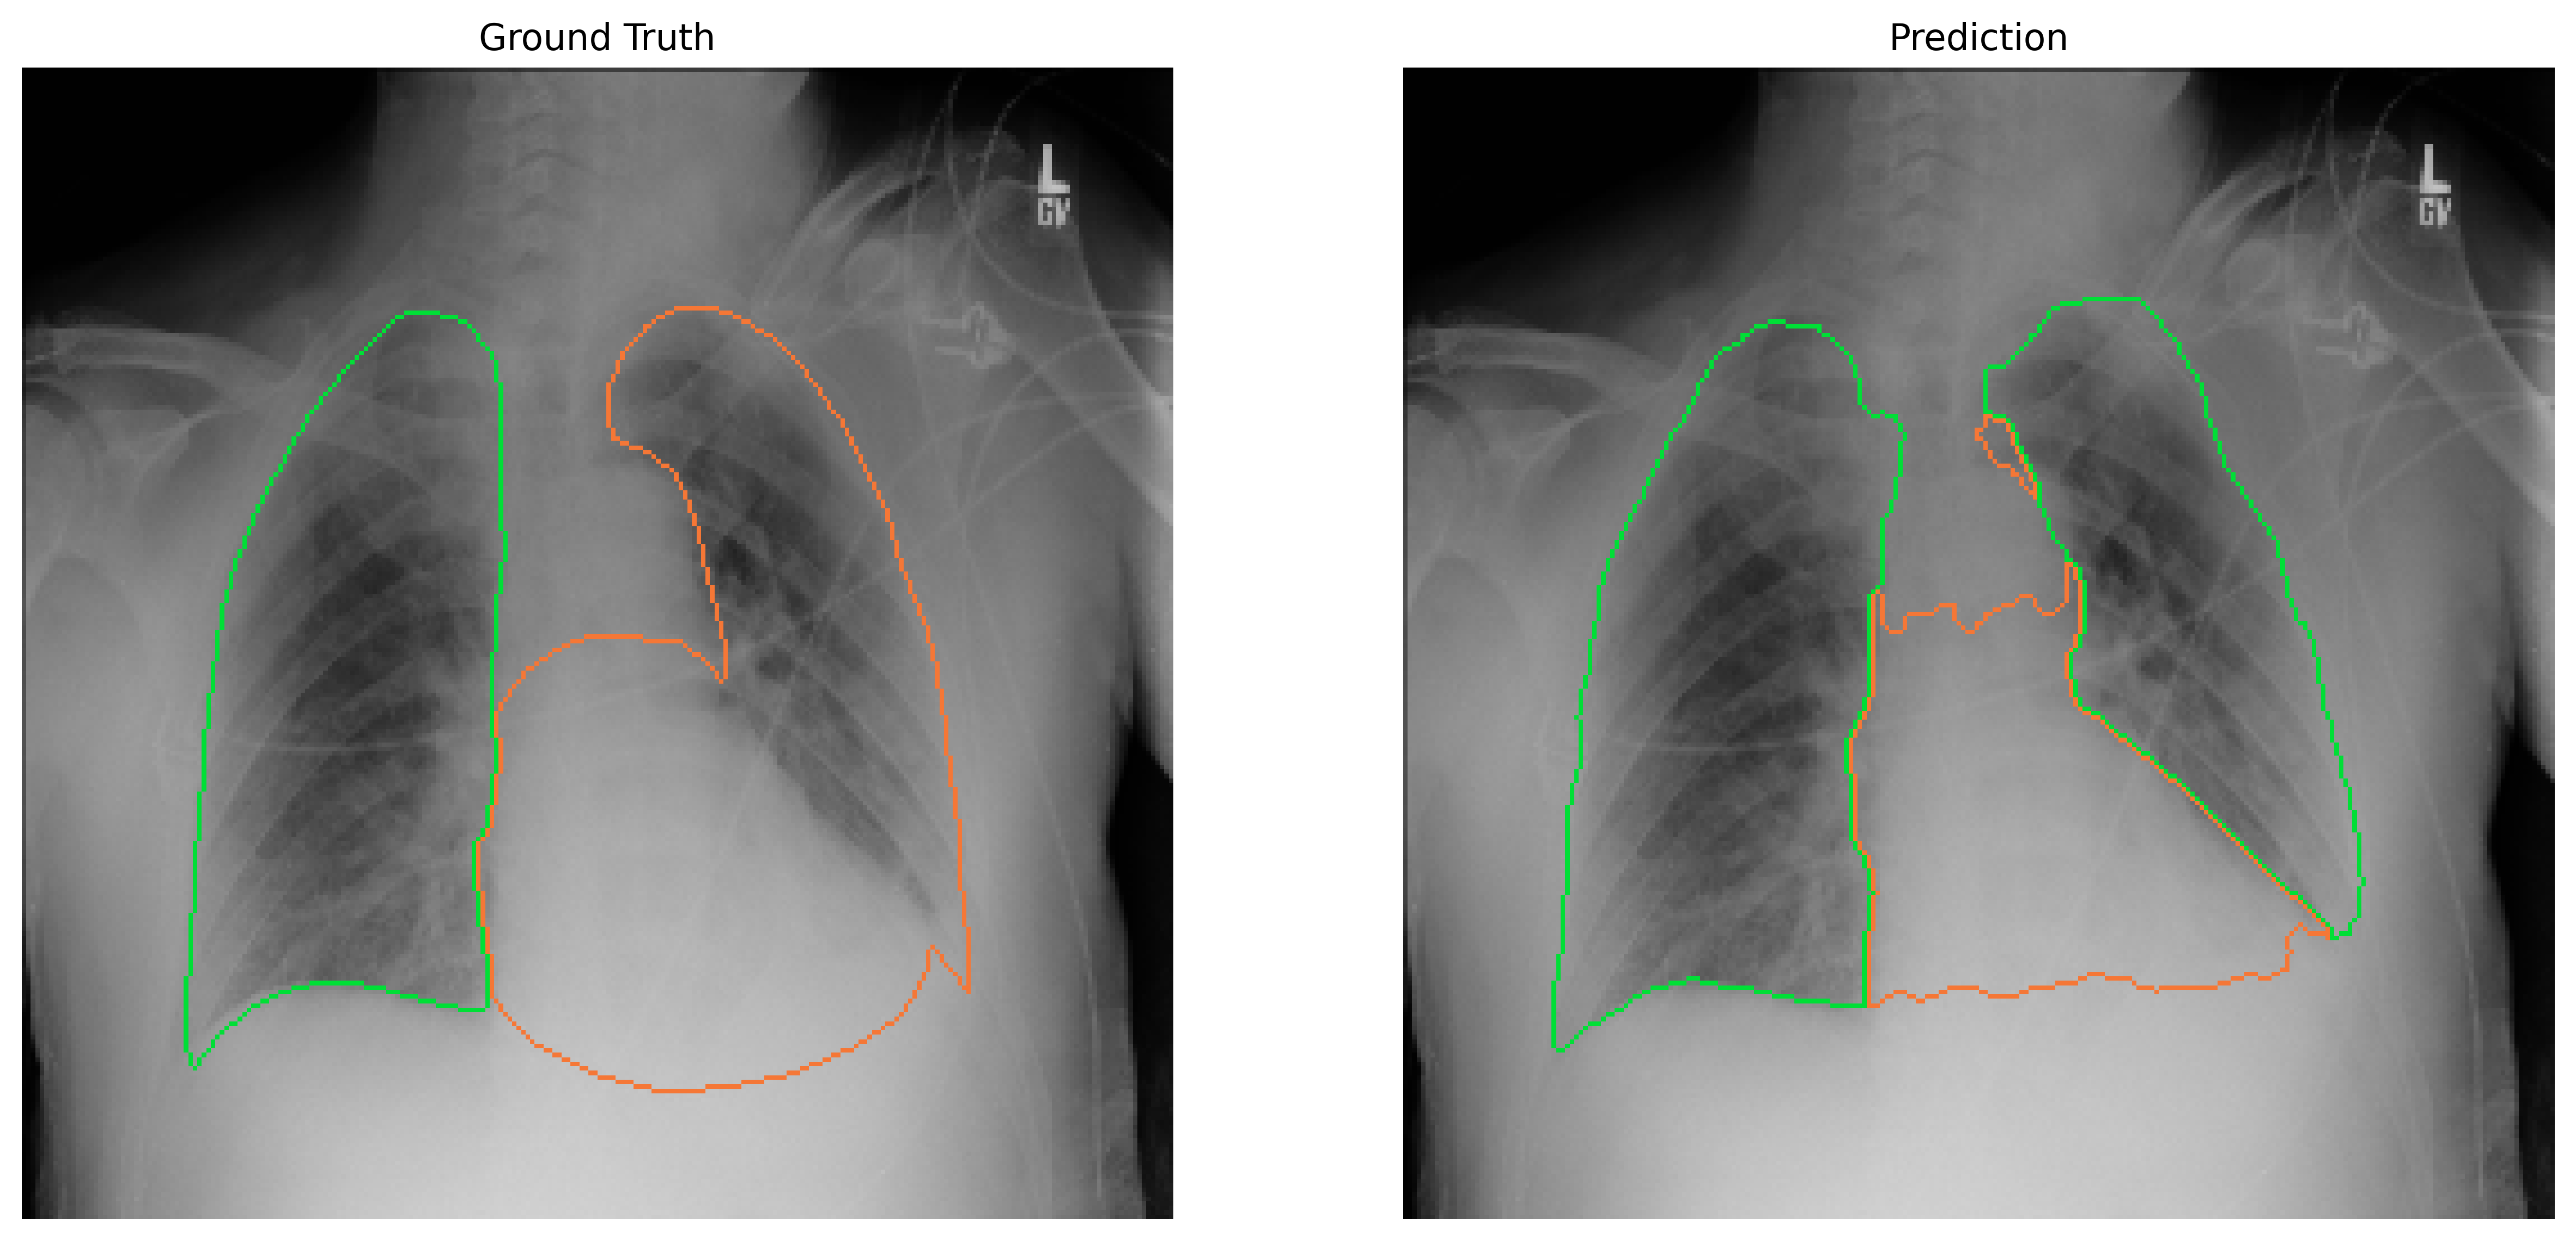

In [23]:
image_iterator = iter(dataloader)

img, tp_map, hv_map, np_map = next(image_iterator).values()
pred_img = infer_step(img.to("cpu"), conic_model.to("cpu"))
instance_info = process(pred_img[0], nr_types=7, return_centroids=True)
visualization_img = visualize_instances_dict(
    img[0],
    instance_info[1],
    draw_dot=False,
    line_thickness=1,
    type_colour={
        0: ["nolabe", [0, 0, 0]],
        1: ["neutrophil", [245, 119, 54]],
        2: ["epithelial", [0, 223, 54]],
        3: ["lymphocyte", [255, 0, 8]],
        4: ["plasma", [0, 193, 252]],
        5: ["eosinophil", [0, 86, 197]],
        6: ["connective", [223, 221, 151]],
    },
)

grouth_truth = torch.concat(
    [tp_map.unsqueeze(-1), np_map.unsqueeze(-1), hv_map], dim=-1
)
grouth_truth_instance_info = process(
    grouth_truth[0].numpy(), nr_types=7, return_centroids=True
)
visualization_img_grouth_truth = visualize_instances_dict(
    img[0],
    grouth_truth_instance_info[1],
    draw_dot=False,
    line_thickness=1,
    type_colour={
        0: ["nolabe", [0, 0, 0]],
        1: ["neutrophil", [245, 119, 54]],
        2: ["epithelial", [0, 223, 54]],
        3: ["lymphocyte", [255, 0, 8]],
        4: ["plasma", [0, 193, 252]],
        5: ["eosinophil", [0, 86, 197]],
        6: ["connective", [223, 221, 151]],
    },
)

figure, axes = plt.subplots(1, 2, figsize=(15, 15), dpi=400)
axes[0].imshow(visualization_img_grouth_truth)
axes[1].imshow(visualization_img)

axes[0].set_title("Ground Truth")
axes[1].set_title("Prediction")

axes[0].set_axis_off()
axes[1].set_axis_off()

In [11]:
type_statistics = [0 for i in range(7)]
for i in instance_info[1].values():
    type_statistics[int(i["type"])] += 1


type_statistics_grouth_truth = [0 for i in range(7)]
for i in grouth_truth_instance_info[1].values():
    type_statistics_grouth_truth[int(i["type"])] += 1

In [12]:
type_colour={
    0: ["nolabe", [0, 0, 0]],
    1: ["neutrophil", [245, 119, 54]],
    2: ["epithelial", [0, 223, 54]],
    3: ["lymphocyte", [255, 0, 8]],
    4: ["plasma", [0, 193, 252]],
    5: ["eosinophil", [0, 86, 197]],
    6: ["connective", [223, 221, 151]],
}

print('Number of cells and type statistics')
print(f'Total cell: {len(instance_info[1].values())}, {len(grouth_truth_instance_info[1].values())}')
total_cell = 0
for idx, value in enumerate(type_statistics):
    data = type_colour[idx]
    data_ground_truth = type_colour[idx]
    print(f'{data[0]} = {value, type_statistics_grouth_truth[idx]}')


Number of cells and type statistics
Total cell: 4, 2
nolabe = (0, 0)
neutrophil = (2, 1)
epithelial = (2, 1)
lymphocyte = (0, 0)
plasma = (0, 0)
eosinophil = (0, 0)
connective = (0, 0)
